In [2]:
import ttide as tt
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi, cos, sin, fft
from datetime import datetime, date
from datetime import timedelta
from utide import solve, reconstruct
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
import utide

%load_ext autoreload
%autoreload 2
import sys
import os
from pathlib import Path

sys.path.append(os.getcwd())

tide_path=os.path.abspath(os.path.curdir)+"/mydata/"
sys.path.append(str(tide_path)) # add the folder to the list of paths 

from mycode.specter import specter

# On Tides and Tidal Analysis

<img align="left" width="30%" style="padding-right:10px;" src="Images/Ccom.png">

## Adapted From Jim Irish (UNH OE), 2019
### Adapted by Semme J. Dijkstra 2020

# Fort point, New Castle, NH

<img align="left" width="40%" style="padding-right:10px;" src="Images/fort_point_1.png">
<img align="left" width="40%" style="padding-right:10px;" src="Images/fort_point_2.png">

  <br><br> This gauge will be decommissioned in 2020

# Jackson Lab, Durham, NH

<img align="left" width="70%" style="padding-right:10px;" src="Images/jackson_lab.png">

  <br><br> This gauge was commissioned as part of CCOM/JHCs educational program

Learn more detail about: ...


# Bottom Pressure Measurement

In the case where the ocean is in approximate static equilibrium, the vertical equation of motion becomes the hydrostatic equation, and this can be integrated from the top of the atmosphere ($\infty$) to the bottom of the ocean ($-h$) to obtain the pressure observed by the instrument deployed there. 

$$P_{-h}(t)=\int_{-h}^{\infty} \rho(z,t) \cdot g \cdot dz$$

We can break this up into several pieces as follows:

$$P_{-h}(t)=\int_{\eta}^{\infty} \rho_{atm}(z,t) \cdot g \cdot dz + 
            \int_{0}^{\eta} \rho_{0}(z,t) \cdot g \cdot dz + 
            \int_{-h}^{0} \rho_{avg}(z,t) \cdot g \cdot dz +
            \int_{-h}^{0} \rho'(z,t) \cdot g \cdot dz$$
            
The integral from the top of the atmosphere ($z=\infty$) to the sea surface ($z=\eta$) is just the atmospheric pressure, $P_{atm}$. 

The sea surface is generally not smooth, but consists of waves whose elevation we describe by $\eta$ as a function of time.  Thus the next term is the integral from the sea surface ($z=\eta$) to the mean sea level ($z=0$).  This then is a pressure due to the surface waves that we approximate as the surface density, $\rho_0$, times the elevation $\eta$.  However, remember that surface wave effects decrease with depth as $e^{-k\cdot z}$ where $k$ is the surface wave wavenumber ($k = 2\pi/\lambda$) and $z$ the depth.

The next term involves the integral from the mean sea level ($z=0$) to the sea floor ($z=-h$).  We shall break this further up into terms depending on the density.  The first is the average density, $\rho_{avg}$, times the mean depth $-h$ and is just the mean hydrostatic pressure seen by the bottom pressure sensor.

The final term is the deviation from the mean density where
			 $$\rho(z) = \rho_{avg} + \rho’(z,t)$$
             
where the perturbation density $\rho’$ contains the effects of internal density changes on the bottom pressure. 



Learn more detail about: ...

# Bottom Pressure Measurement

Then we can write the pressure our bottom instrument sees as the contribution of these terms:

$$P_{-h}(t)=P_{atm}(t)+\rho_0(t)\cdot g \cdot\eta (t) \rho_{avg}\cdot g \cdot h + \int_{-h}^{0} \rho'(z,t) \cdot g \cdot dz$$
            
So we see the signal we see at the bottom is due to: 
- the atmospheric pressure
- the contribution due to the waves and other deviations of the sea level from its mean position
- the average hydrostatic pressure due to the depth of the water
- the contribution due to internal density changes.  Which in shallow water situations is small


Learn more detail about: ...

# Bottom Pressure Measurement

Solving for the time varying sea level variation, $\eta(t)$, as a function of the time varying density:

$$\eta(t) = \frac{P_{-h}(t) - P_{atm}(t)}{\rho_0(t)\cdot g} - constant$$
            
The term in curly brackets is the differential pressure that the Bubbler tide gauge at Jackson Lab measures.  This can also be calculated from an absolute pressure sensor and a nearby atmospheric pressure sensor

The correction $\rho(t)\cdot g$ is a time varying term that changes with time and should be measured.


# $\rho(t)\cdot g$ Correction from MicroCAT at Jackson Estuarine Lab

<img align="left" width="70%" style="padding-right:10px;" src="Images/density_gravity_corrn.png">

Reminder:  

# Sine Wave

A sine wave is a continuous smooth periodic oscillation. Sine waves occur in tidal motion due to the periodic motion of the Earth and astronomical bodies. In tides we tend to use the $1/2 \pi$ complement to the sine, known as the cosine

$$\eta(t) = A\cdot cos(f\cdot t + \theta)$$


where:

- A: amplitude
- f: frequency or the cycles per second
- $\theta$:  phase of cycle at $t=0$

# Line Spectra

In the top plot generated by the code cell below you see a 1024 point sine wave signal with a 43 point cycle. The power spectrum of that signal is given by the bottom plot. In this case you might expect a single peak at exactly $f=1/43$, however this is not the case, which is due to the limitations of the fft algorithm that relies on the system being continuous.

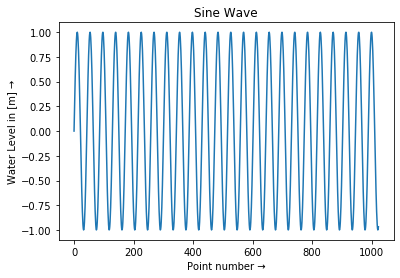

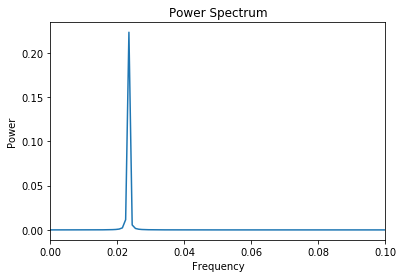

In [4]:
plt.figure();
n = 1024
s = int(n/2)
t = np.arange(n)
f = 1/43
A = 1
eta = A*sin(2*pi*f*t)  # Create a sinusoid
plt.plot(eta)
plt.title('Sine Wave')
plt.ylabel('Water Level in [m] →') 
plt.xlabel('Point number →') 
plt.show()
plt.figure();         # Show the sinusoid
Fk = fft.fft(eta)/n   # The FFT of the signal
nu = fft.fftfreq(n,1) # The natural frequencies in the spectrum
plt.plot(nu[0:s],np.absolute(Fk[0:s])**2) # Plot the power spectrum
plt.title('Power Spectrum')
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.xlim(0,0.1)
plt.show()


# Astronomical Frequencies

The tide generating forces are cyclical forces due to gravity acceleration of various astronomical processes. For tidal modeling there are 6 associated frequencies of particular importance 

$f_1$ = 1 cycle per lunar day = earth rotation (high moon to high moon) = 24.84 hours = 14.4921º/hr<br>
$f_2$ = 1 cycle per month = moon around earth = 27.3216 mean solar days = 0.544º/hr<br>
$f_3$ = 1 cycle per year = earth around sun = 365.2422 mean solar days = 0.0411º/hr<br>
$f_4$ = 1 cycle per 8.85 Julian years (365.25 days) = lunar perigee<br>
$f_5$ = 1 cycle per 18.61 Julian years = regression of the nodes<br>
$f_6$ = 1 cycle per 20,900 years = solar perigee<br>

# Tidal Frequencies

To determine the tidal elevation $\eta(t)$ we may use the expression:

$$\eta(t) = \Sigma_k\cdot A_k\cdot cos(f_k\cdot t + \theta_k)$$


where:

- $A_k$: amplitude of tidal constituent $k$
- $f_k$: frequency of tidal constituent $k$
- $\theta_k$:  phase of tidal constituent $k$

The tidal frequencies $f_k$ are combinations of the basic astronomical frequencies

# Darwin Symbol

Darwin symbols are shortcuts to identifying a tidal frequencies e.g., $M1, O1, K1, N2, M2, S2, M4$.

The principle tidal frequencies are identified by their Darwin Symbol which is related to the daily, monthly and yearly tides.

The 8 and 18 year tides are  handled separately as will be discussed later. 

The number in a Darwin Symbol represents the species, or the number of cycles per day of that constituent.  

# A Word on the Tidal Phases

In the discussion of the determination of the tidal frequencies from the tidal equation the phase $\theta_k$ and amplitude $A_k$ at each constituent were used. You have to use care with the phase term $\theta_k$ as it is dependent on the time reference frame used

- $G$ = Greenwich Epoch = phase lag of the observed tide behind the passage of the sun or moon over Greenwich Meridian with time kept in UTC.  
- $g$ = same as $G$ but uses local time rather than UTC.
- $\kappa$ = local Epoch = phase lag of the observed tide behind the passage of the sun or moon over the local meridian.
    - Where $G = k + s\cdot$*local West longitude*<br>
      $s$ = species with 0 for long period, 1 for diurnal, 2 for semi-diurnal, etc.  
      
**For plotting the spatial structure of the tide, you want the Greenwich Epoch (G) rather than the local epoch!**



# Spectrum of Tidal Constituents (AKA Tide Lines)

<img align="left" width="70%" style="padding-right:10px;" src="Images/Hartman-and-Wenzel_tidal_spectrum.png">

Source: Hartmann T. and Wenzel H.G., 1995, The HW95 tidal potential
catalogue. Geophys. Res. Lett, 22, 3553–3556.

# Additional Considerations

## Tides of the solid earth.  

The surface of the earth rises and falls up to 30 cm due to the forcing of the sun and moon.  The earth tides are generally in equilibrium with the tidal potential. The Love numbers describe the elasticity of the earth in response to the gravitational forcing.  

## Tides of the solid moon

seismometers on the moon show that there are “moon” tides due to the gravitational attraction of the sun.

# Tidal Analysis Methods

## 1 Harmonic Method – NOAA/NOS
Original Method 
– Fourier Transform at tidal frequencies 
– Requires 1 month or 1 year records with no gaps



## 2 Least Squares – UTide
    Fits predicted tide to observed in least squares sense – Daniel Codiga

- Records may have gaps
- Any length record, but longer than 1 year break up.  

### Relative Performance
For long, “clean” records, the results from these methods are statistically the same. 

# Analysis Methods 1 Harmonic Method – NOAA/NOS

- First tidal analysis was a Fourier transform at tidal frequencies given by astronomy - done by hand. No need for a full transform. 
- The transform gives phase relative to the record start and it needs to be adjusted relative to astronomy.     
- NOAA normally uses 1 month or 1 year record lengths to get around windowing problems.

## Nodal Correction

Analysis on 1 year or less of data can not resolve 8 and 18.6 year effects. 
Therefore, use Darwin Symbols like M2 to “name” the frequency, and adjust the amplitude and phase of a one year record for the 8 and 18.6 yr tides by:
      $$\eta(t) = \Sigma a_k\cdot A_k\cdot cos(f_k t + \theta_k+ b_k)$$
      
Where $ak$ and $bk$ are “nodal” corrections in amplitude and phase for a record < 1 year at the midpoint of the record.

- Analysis is by Fourier transform at the tidal frequency.  The frequency is determined quite accurately by astronomy – M2 = 1.93227361 Cycles Per Day (`cpd`)
- Analysis is done on the largest of the constituents as determined by equilibrium theory (e.g. M2 = 0.90812, and O1 = 0.37689).
- NOAA uses 25 constituents (including higher harmonics e.g. M4, M6) to make a normal analysis. (Other routines use up to 49 constituents.)   
- For short records (e.g. 1 month), 5 constituents are analyzed and the rest of the constituents (up to 49) are inferred from equilibrium theory. 
- The analysis selects the part of the signal which is in constant amplitude and phase relation with the observed at a constituent's frequency.

## Nodal Correction

The crux of a tidal analysis is how to analyze for the tidal part of the water level signal without including “noise.”
There is “noise” in all geophysical data, so any analysis must consider how to separate the tidal signal from the background noise i.e., how to separate the Signal to Noise Ratio (`SNR`).

For a good prediction, you do not want to predict all the variance (non tidal energy) in the record, but just the tidal part. As an example of harmonic analysis, take a bottom pressure record.


Spectrum of water level at Fort Point in New Castle, NH

# Prediction

Once you have analyzed a record for the harmonic constants (e.g., M2  0.389 m  006.1º) you can predict the tide for any other time for that place. It is important that you understand that classical tidal analysis and prediction are only valid for only one point in space

Before the advent of modern digital computers prediction was done using a tide generating machine. Tide generating machines are mechanical devices.

<img align="left" width="70%" style="padding-right:10px;" src="Images/tide_prediction_machine.png">
<br><br>
Tide Machine: Amplitude is set by length of arm (K), Phase is set by the position of the arm and the pulleys sum the results, finally the pen marks the predicted tide from the various constituents on paper.


in WW II there was one machine in England and one NOAA headquarters in Maryland. These machines were hidden during WWII as they were of key importance to supplying information for the Normandy invasion, and others. The Germans had their own tidal predicting machine.  

The tide predicting machines were complex mechanical systems where the amplitude and phase for each constituent were set and machine summed the results for a prediction.  


# NOAA Mechanical Tide Prediction

Once you have analyzed a record for the harmonic constants (e.g., M2  0.389 m  006.1º) you can predict the tide for any other time for that place. It is important that you understand that classical tidal analysis and prediction are only valid for only one point in space

Before the advent of modern digital computers prediction was done using a tide generating machine. Tide generating machines are mechanical devices.

<img align="left" width="50%" style="padding-right:10px;" src="Images/noaa_tp_machine_1.png">
<img align="left" width="50%" style="padding-right:10px;" src="Images/noaa_tp_machine_2.png">
<img align="left" width="50%" style="padding-right:10px;" src="Images/noaa_tp_machine_3.png">
<img align="left" width="50%" style="padding-right:10px;" src="Images/noaa_tp_machine_4.png">

<br><br><br>

This machine was designed by Rollin A. Harris and E.G. Fischer and constructed in the instrument shop of the U.S. Coast and Geodetic Survey in 1910 and replaced the earlier Ferrel Machine in 1912. 

The machine is about 11 feet long, 2 feet wide, and 6 feet high, and weighs approximately 2,500 pounds. The principal features are: 
- the supporting framework
- a system of gearing by means of which shafts representing the different constituents are made to rotate with angular speeds proportional to the actual speeds of the constituents 
- a system of cranks and sliding frames for obtaining harmonic motion
- summation chains connecting the individual constituents elements, by means of which the sums of the harmonic terms are transmitted to the recording devices
- a system of dials and pointers for indicating in a convenient manner the height of the tide for successive instants of time and also the time of the high and low waters; 
- a tide curve or graphic representation of the tide automatically constructed by the machine. 

The machine was designed to take account of the following 37 constituents: 

$J1, K1, K2, L2, M1, M2, M3, M4, M6, M8, N2, 2N2, O1, OO1, P1, Q1, 2Q1, R2, S1, S2, S4, S6, T2, lambda2, µ2, nu2, rho1, MK, 2MK, MN, MS, 2SM, Mf, MSf, Mm, Sa, Ssa$.



# Analysis Method 2 Least Squares and UTide


Utide constitutes algorithms for a least squares fitting of observations to tides to get the standard tidal constituents. Utide is a follow on to T_tide which originated as Fortran code derived from software by Mike Foreman of Pat Bays Labs, IOS, Canada. T_Tide and UTide are available as GIT repositories. Here we will use UTide to stay consitent with labs from previous years

Following is an example of using UTide on a bottom pressure record from the UNH-OOA site. 





## Bottom Pressure Record

- Pressure is measured by sensor in the bottom Seacat (SBE-16Plus) about 1.5 meters above the bottom.  

- Statistics of the record are:
    - Maximum = 55.36 dbars
    - Minimum = 50.10 dbars
    - Mean = 52.4929 dbars
    - Variance = 0.9172 dbars² - (energy in record) 
        - for a sinewave is $Variance = \frac{1}{2}A^2$ or $Variance = \Sigma(value-mean)^2$
- Where 1 dbar is about 1 m of sea level

<img align="left" width="100%" style="padding-right:10px;" src="Images/t_tide_results.png">


# Assignment: Analysis of Two Tide Gauge Records

## 1 Read in the Fort Point Data

Read and plot the Fort Point Data



In [3]:
# 1.0 Read the file 
# Open, read and close the file
 
wl_file = open(str(tide_path)+'/fortPoint.txt')
wl_content = wl_file.read()
wl_file.close()
        
# 1.1 Parse the contents

# Split the file into lines (Each line representing a record)

wl_lines = wl_content.splitlines()

# Determine the number of records

nr_records = len(wl_lines) # Determine the number of lines (records) in the file

# Allocate memory for the water levels (ttide uses numpy arrays)
wl_fp = np.zeros(nr_records) #  nr_records x 1 array to hold the water levels from Fort Point

# Create a list to hold the associated times

t_fp = []

for idx, wl_record in enumerate( wl_lines):
    
    # Tokenize the record
    obs = wl_record.split()
    
    # Add the time to the t_fp list 
    
    t_fp.append(datetime(int(obs[1][0:4]),int(obs[1][4:6]),int(obs[1][6:8]),int(obs[2]), 0, 0))
    
    # Add the water level to the array wl_fp
    wl_fp[idx]=float(obs[4])
    
# Set the latitude of the Fort Point Gauge (in degrees!)

lat_fp = 43.07



## 1.0 Open and Read Data from Fort Point

In the code cell above open the text file `fortPoint.txt` contained in your `mydata` folder and read the contents into a list variable called `wl_content`. 


## 1.1 Parse the data

Create an empty nx2 array called `wl_fp` to hold the water level data, the first column will hold the time in seconds since the first record for each record

Each successive element of the list should contain a line (record) of the data file. In a for loop go through all the records and add the last field to the list `wl_fp`. Assign the number of records to the variable `nr_records`

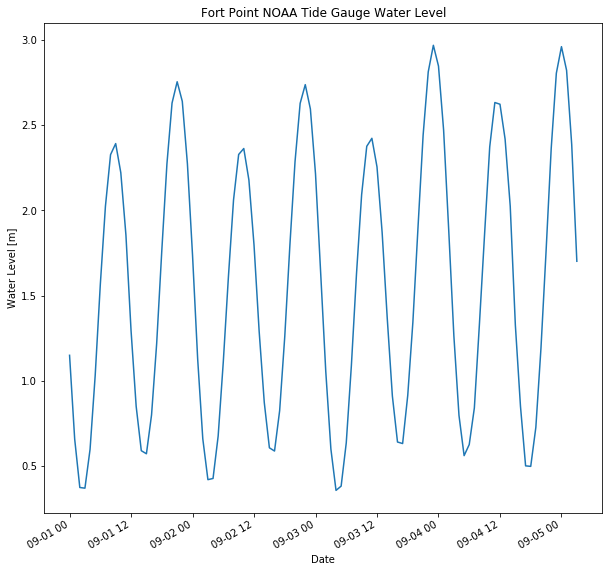

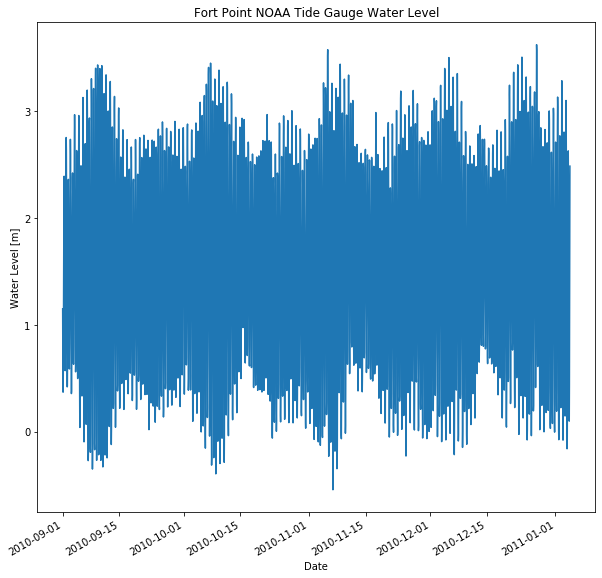

In [4]:
# 1.2 Plot the Fort Point Data 

# Plot the first 100 records
plt.figure(figsize=(10, 10))
plt.plot(t_fp[:100],wl_fp[:100])
plt.title('Fort Point NOAA Tide Gauge Water Level')
plt.ylabel('Water Level [m]')
plt.xlabel('Date')
plt.gcf().autofmt_xdate() # Make the x-label more readable

# Plot the entire data set
plt.figure(figsize=(10, 10))
plt.plot(t_fp,wl_fp)
plt.title('Fort Point NOAA Tide Gauge Water Level')
plt.ylabel('Water Level [m]')
plt.xlabel('Date')
plt.gcf().autofmt_xdate() # Make the x-label more readable

Assignment 1:

In this assignment you are expected to create a report. Present your results in a ***coherent narrative*** form with ample photos, illustrations, figures and/or tables—do **not** submit an answer sheet type of submission. 

    Create a front page identifying you and the title of this lab (Tidal Analysis using UTide)
    
    In section 1. describe the Fort Point Tide Station, addressing:
        1.1 the location, 
        1.2 the gauge type and arrangement
        1.3 the benchmarks
        1.4 the available datums. 
     
     In section 2 Show plots of the observed data:
        2.1 Show the full tidal record
        2.2 Show a zoom in
        2.3 Discuss observations that you may make from just looking at the plots

## 1.2.0 Plot 100 Records of the Fort Point Data

In the code cell above complete the code to plot the first hundred data records. Make it so that the title reads `Fort Point NOAA Tide Gauge Water Level`, the y-axis label reads `Water Level [m]` and the x-axis label reads `Date`.


## 1.2.1 Plot All Records of the Fort Point Data

Create a plot with the same properties as the one from step 1.2.0, but now showing all the records for the Fort Point data file

In [94]:
time_fp = mdates.date2num(t_fp)

c_fp = utide.solve(time_fp,wl_fp,lat=lat_fp,method='ols',conf_int='MC',trend=False)

print('')
print(f"{'Darwin':>9}"f"{'freq':>10}",f"{'Amp':>9}",f"{'95ci%':>9}",f"{'phase':>9}",f"{'95ci%':>9}",f"{'SNR':>9}")
for idx, const in enumerate( c_fp.name):
    print("%9s% 10.4f% 10.4f% 10.4f% 10.2f% 10.2f% 10.2f" \
          %(const, c_fp.aux.frq[idx], c_fp.A[idx],c_fp.A_ci[idx],c_fp.g[idx],c_fp.g_ci[idx],c_fp.diagn['SNR'][idx]))


solve: matrix prep ... solution ... diagnostics ... done.

   Darwin      freq       Amp     95ci%     phase     95ci%       SNR
       M2    0.0805    1.2938    0.0094    105.91      0.37  72277.78
       N2    0.0790    0.3037    0.0089     68.81      1.89   4479.06
       S2    0.0833    0.1938    0.0090    131.41      2.58   1776.00
       K1    0.0418    0.1435    0.0063    196.10      2.43   2007.21
       O1    0.0387    0.1086    0.0069    182.94      3.22    952.40
       L2    0.0820    0.0884    0.0084    162.68      6.04    421.01
      MSF    0.0028    0.0293    0.0255    122.72     65.16      5.06
      MU2    0.0777    0.0205    0.0091    122.99     24.69     19.40
       MM    0.0015    0.0189    0.0241     92.61     75.35      2.35
       M4    0.1610    0.0160    0.0008    325.97      2.95   1482.15
       Q1    0.0372    0.0154    0.0057    146.30     20.45     28.46
       J1    0.0433    0.0113    0.0064    213.53     28.83     11.92
      NO1    0.0403    0.0107  

Assignment pt 2:

Add a section 3
    
    In section 3. describe the Fort Point Tide Tidal Coefficients retrieved using utide, addressing:
        3.1 Identify and discuss the 5 major tidal constituents
        3.1.1 Discuss whether you should consider adding L2
        3.2 Why would you use only constituents with signal to noise ratio greater than 2 in the prediction?
        3.3 Discuss the type of tide at Fort Point and how you determined it ((diurnal mixed, or semidiurnal)


## Analyze the tide using UTide

I have already installed the t_tide library for you. At the top of this notebook it is imported as `tt`. We will use ttide to  do the tidal analysis for you

In [6]:
# Predict the tides using the outcome of the tidal analysis
tide_fp = utide.reconstruct(time_fp, c_fp)

prep/calcs ... done.


## Predict the Tide Using UTide

In the code cell above 

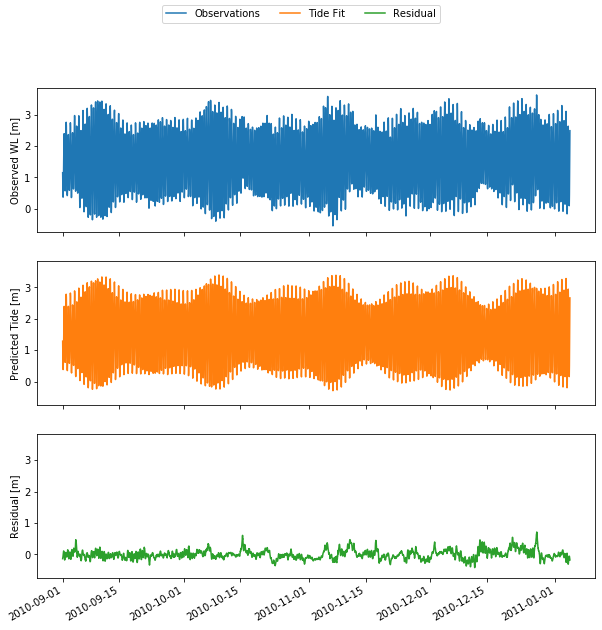

In [7]:


fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True,figsize=(10, 10))

ax0.plot(t_fp, wl_fp, label=u'Observations', color='C0')
ax0.set_ylabel('Observed WL [m]')
ax1.plot(t_fp, tide_fp.h, label=u'Tide Fit', color='C1')
ax1.set_ylabel('Predicted Tide [m]')
ax2.plot(t_fp, wl_fp - tide_fp.h, label=u'Residual', color='C2')
ax2.set_ylabel('Residual [m]')
ax2.xaxis_date()
fig.legend(ncol=3, loc='upper center')
fig.autofmt_xdate()

## Compare the Predicted and Residual Tides

Use the code cell above to plot to create a set of 3 subplots positioned above eachother using a single set of x-axis labels. Label the axis 

Assignment pt 3:

Add a section 4
    
    In section 4. describe the properties of the residuals
        4.1 Discuss what do the residual represent (numerically)
        4.2 Discuss the portion of the water level variation represented by the residual 
        4.3 Discuss the time dependence of the variations in the residual through the time series
        4.3.1 Discuss what might be the cause of the variations?


In [96]:
c_fp.name[1:2]

array(['N2'], dtype=object)

prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.


<Figure size 720x720 with 0 Axes>

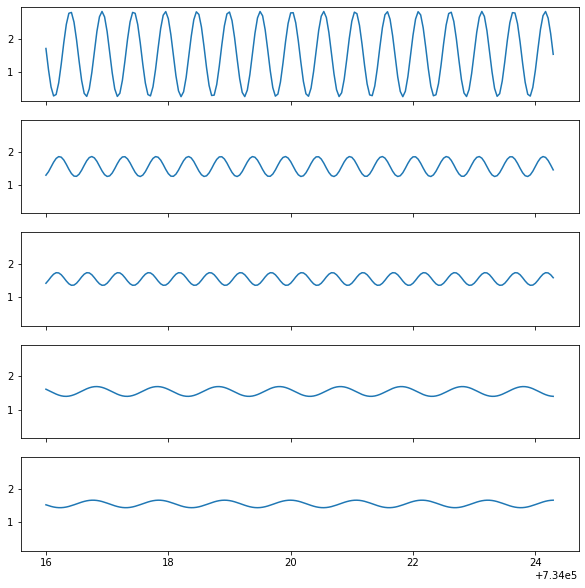

In [97]:
# make prediction for 5 most significant constituents at Fort Point


pred_M2_fp = utide.reconstruct(time_fp[0:200], c_fp,constit=c_fp.name[0:1])
pred_N2_fp = utide.reconstruct(time_fp[0:200], c_fp,constit=c_fp.name[1:2])
pred_S2_fp = utide.reconstruct(time_fp[0:200], c_fp,constit=c_fp.name[2:3])
pred_K1_fp = utide.reconstruct(time_fp[0:200], c_fp,constit=c_fp.name[3:4])
pred_O1_fp = utide.reconstruct(time_fp[0:200], c_fp,constit=c_fp.name[4:5])


plt.figure(figsize=(10, 10))
fig, (ax0, ax1, ax2,ax3,ax4) = plt.subplots(nrows=5, sharey=True, sharex=True,figsize=(10, 10))
ax0.plot(time_fp[0:200],pred_M2_fp.h)
ax1.plot(time_fp[0:200],pred_N2_fp.h)
ax2.plot(time_fp[0:200],pred_S2_fp.h)
ax3.plot(time_fp[0:200],pred_K1_fp.h)
ax4.plot(time_fp[0:200],pred_O1_fp.h)


Assignment pt 4:

Analyze the code cell above and make sure that you understand what it is doing. Demonstrate your understanding by updating the code in the code cell above so that there is appropriate labeling. You may look at the previous code cells to get inspiration on how to do this

Add a section 5
    
        5.1 Add the plot from the updated code section of the code cell above and discuss what this shows you


     Number of blocks in transform = 2.0
     *** transforming ***
     *** Smoothing ***
['     NUMBER OF SMOOTHED POINTS  = 385']


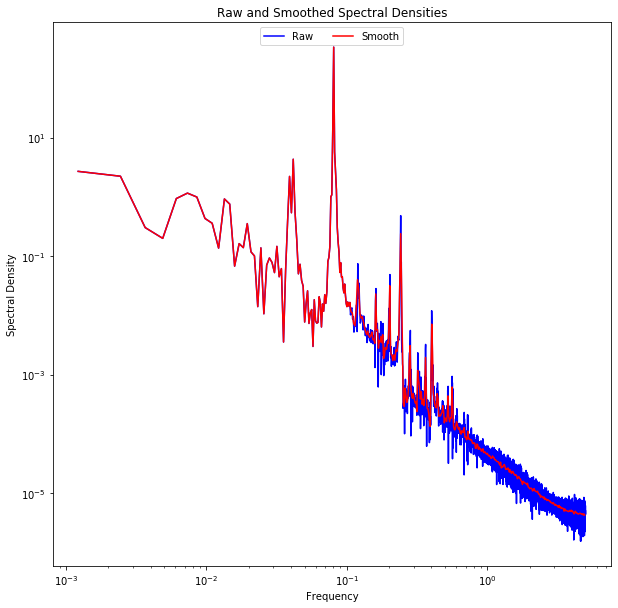

In [18]:
spec_jl = specter(wl_jl,2**13,.1,.005) 

Assignment pt 5:

In the code cell above a spectral analysis is done using `specter` and the results are plotted in a loglog plot

    5.1 Discuss what this plot shows you
    5.2 There is a raw and a smoothed curve, why would you smooth the curve?

In [128]:
energy_all = sum(c_fp.A**2)
energy_all
100*c_fp.A[idx]**2)/energy_all

1.8468334618234052

In [135]:
## Update this
print('')
print(f"{'Darwin':>9}"f"{'Energy Percentage':>20}")
for idx, const in enumerate( c_fp.name):
    print("%9s          %10.4f"%(const,100*c_fp.A[idx]**2/energy_all))



   Darwin   Energy Percentage
       M2             90.6442
       N2              4.9956
       S2              2.0336
       K1              1.1145
       O1              0.6383
       L2              0.4232
      MSF              0.0465
      MU2              0.0228
       MM              0.0193
       M4              0.0139
       Q1              0.0128
       J1              0.0069
      NO1              0.0062
       M6              0.0044
     UPS1              0.0028
      OO1              0.0026
      MN4              0.0025
     2MN6              0.0021
     EPS2              0.0014
      MS4              0.0011
      MO3              0.0010
      2Q1              0.0009
      MK3              0.0008
     2MS6              0.0006
       M3              0.0004
     ALP1              0.0004
     ETA2              0.0003
     2MK5              0.0003
       M8              0.0002
      SK3              0.0002
      SN4              0.0002
     2SK5              0.0001
     3MK7

Assignment pt 6:

Finally, shown above is a percent of energy versus constituent table, what does this tell you about what is important and what is not? 

    5.1 Discuss what this table shows you

# Lab to here - below is just for Illustration

Note that the residuals for Fort Point and the nearby Jackson Lab are almost identical

In [109]:
# 1.0 Read the file 
# Open, read and close the file
 
wl_file = open(str(tide_path)+'/JacksonLab.txt')
wl_content = wl_file.read()
wl_file.close()
        
# 1.1 Parse the contents

# Split the file into lines (Each line representing a record)

wl_lines = wl_content.splitlines()

# Determine the number of records

nr_records = len(wl_lines) # Determine the number of lines (records) in the file

# Allocate memory for the water levels (ttide uses numpy arrays)
wl_jl = np.zeros(nr_records - 1) #  nr_records x 1 array to hold the water levels from Fort Point

# Create a list to hold the associated times

t_jl = []

for idx, wl_record in enumerate( wl_lines[1:]):
    
    # Tokenize the record
    obs = wl_record.split(',')
    
    # Add the time to the t_jl list 
    
    t_jl.append(datetime(year = int(obs[0][0:4]),month = int(obs[0][4:6]),day = int(obs[0][6:8])))
    t_jl[idx]+=timedelta(seconds=float(obs[1]))
    
    # Add the water level to the array wl_fp
    wl_jl[idx]=float(obs[2])
    
# Set the latitude of the Jackson Lab Gauge (in degrees!)

lat_jl = 43.1



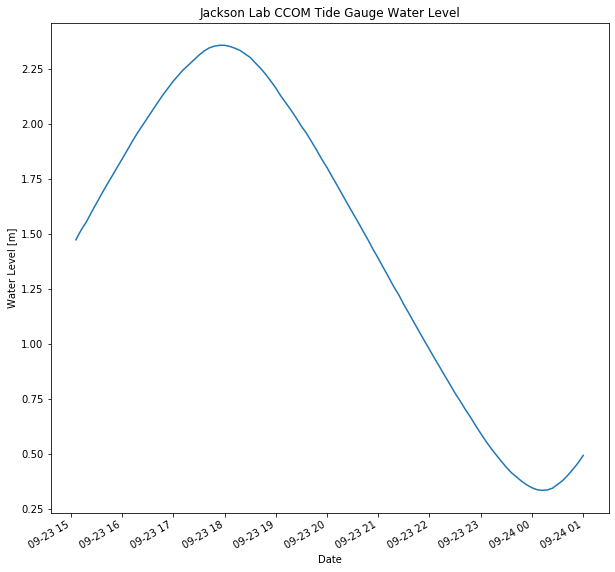

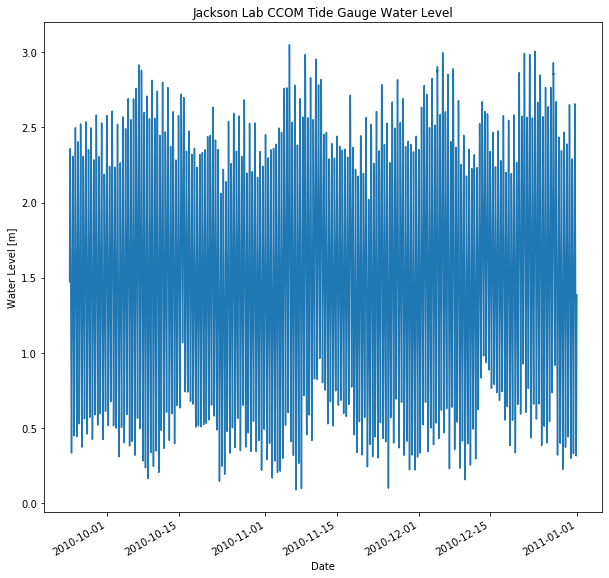

In [110]:
# 2.2 Plot the Jackson Lab data

# Plot the first 100 records
plt.figure(figsize=(10, 10))
plt.plot(t_jl[:100],wl_jl[:100])
plt.title('Jackson Lab CCOM Tide Gauge Water Level')
plt.ylabel('Water Level [m]')
plt.xlabel('Date')
plt.gcf().autofmt_xdate() # Make the x-label more readable

# Plot the entire data set
plt.figure(figsize=(10, 10))
plt.plot(t_jl,wl_jl)
plt.title('Jackson Lab CCOM Tide Gauge Water Level')
plt.ylabel('Water Level [m]')
plt.xlabel('Date')
plt.gcf().autofmt_xdate() # Make the x-label more readable

In [111]:
time_jl = mdates.date2num(t_jl)

c_jl = utide.solve(time_jl,wl_jl,lat=lat_jl,method='ols',conf_int='MC',trend=True)

print('')
print(f"{'Darwin':>9}"f"{'freq':>10}",f"{'Amp':>9}",f"{'95ci%':>9}",f"{'phase':>9}",f"{'95ci%':>9}",f"{'SNR':>9}")
for idx, const in enumerate( c_jl.name):
    print("%9s% 10.4f% 10.4f% 10.4f% 10.2f% 10.2f% 10.2f" \
          %(const, c_jl.aux.frq[idx], c_jl.A[idx],c_jl.A_ci[idx],c_jl.g[idx],c_jl.g_ci[idx],c_jl.diagn['SNR'][idx]))
    

solve: matrix prep ... solution ... diagnostics ... done.

   Darwin      freq       Amp     95ci%     phase     95ci%       SNR
       M2    0.0805    0.9226    0.0060    165.87      0.36  92155.68
       N2    0.0790    0.1725    0.0062    131.31      1.80   2972.69
       K1    0.0418    0.1189    0.0055    236.27      2.24   1825.84
       S2    0.0833    0.1039    0.0058    198.82      3.09   1252.21
       L2    0.0820    0.0992    0.0055    196.87      3.72   1264.26
       O1    0.0387    0.0855    0.0046    224.03      3.24   1322.38
       MM    0.0015    0.0398    0.0305     92.61     40.11      6.54
      MU2    0.0777    0.0394    0.0052    268.58      9.45    224.38
       M6    0.2415    0.0378    0.0025    136.06      3.89    888.25
      MSF    0.0028    0.0252    0.0273     84.87     64.11      3.28
     2MN6    0.2400    0.0202    0.0018     96.29      6.43    471.67
      MO3    0.1192    0.0131    0.0011    271.04      4.78    510.32
     EPS2    0.0762    0.0127  

In [112]:
# Predict the tides using the outcome of the tidal analysis
tide_jl = utide.reconstruct(time_jl, c_jl)

prep/calcs ... done.


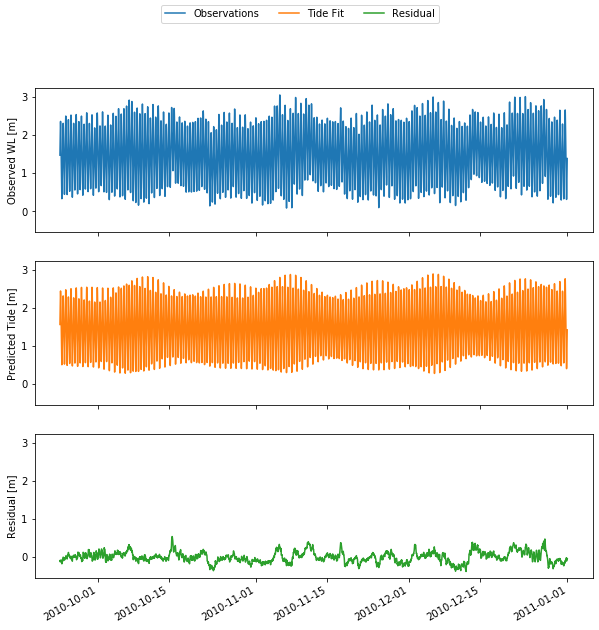

In [113]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True,figsize=(10, 10))

ax0.plot(t_jl, wl_jl, label=u'Observations', color='C0')
ax0.set_ylabel('Observed WL [m]')
ax1.plot(t_jl, tide_jl.h, label=u'Tide Fit', color='C1')
ax1.set_ylabel('Predicted Tide [m]')
ax2.plot(t_jl, wl_jl - tide_jl.h, label=u'Residual', color='C2')
ax2.set_ylabel('Residual [m]')
ax2.xaxis_date()
fig.legend(ncol=3, loc='upper center')
fig.autofmt_xdate()

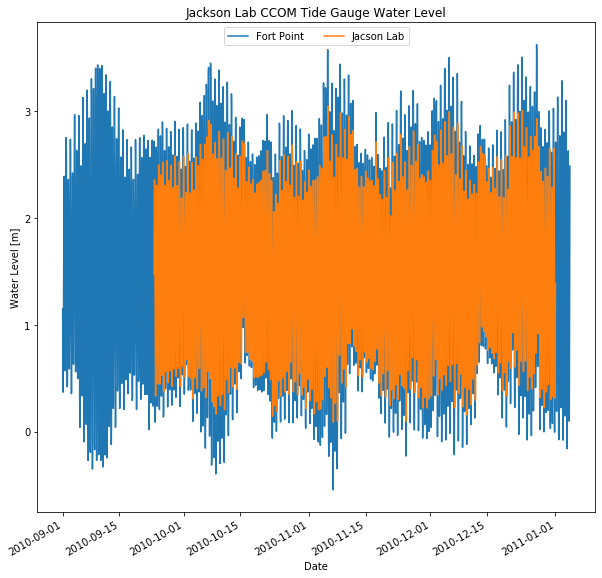

In [114]:
# Plot tide comparison
# Plot the entire data set
plt.figure(figsize=(10, 10))
plt.plot(t_fp,wl_fp,label=u'Fort Point')
plt.plot(t_jl,wl_jl,label=u'Jacson Lab')
plt.title('Jackson Lab CCOM Tide Gauge Water Level')
plt.ylabel('Water Level [m]')
plt.xlabel('Date')
plt.gcf().autofmt_xdate() # Make the x-label more readable
plt.legend(ncol=2, loc='upper center')
plt.show()


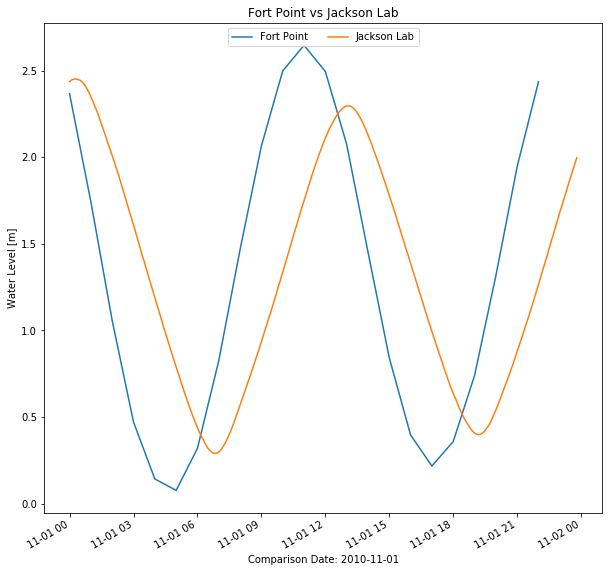

In [115]:
# Show subset of one day of both timeseries

comp_date = date(2010,11,1)
idx_fp_s = -1
idx_fp_e = 0
idx_jl_s = -1
idx_jl_e = 0
for idx, t in enumerate(t_fp):
    if t.date()==comp_date:
        if idx_fp_s == -1:
            idx_fp_s = idx
        else:
            idx_fp_e = idx
            
for idx, t in enumerate(t_jl):
    if t.date()==comp_date:
        if idx_jl_s == -1:
            idx_jl_s = idx
        else:
            idx_jl_e = idx
# Plot tide comparison
# Plot the entire data set
plt.figure(figsize=(10, 10))
plt.plot(t_fp[idx_fp_s:idx_fp_e],wl_fp[idx_fp_s:idx_fp_e],label=u'Fort Point')
plt.plot(t_jl[idx_jl_s:idx_jl_e],wl_jl[idx_jl_s:idx_jl_e],label=u'Jackson Lab')
plt.title('Fort Point vs Jackson Lab')
plt.ylabel('Water Level [m]')
plt.xlabel('Comparison Date: '+str(comp_date))
plt.gcf().autofmt_xdate() # Make the x-label more readable    
plt.legend(ncol=2, loc='upper center')
plt.show()

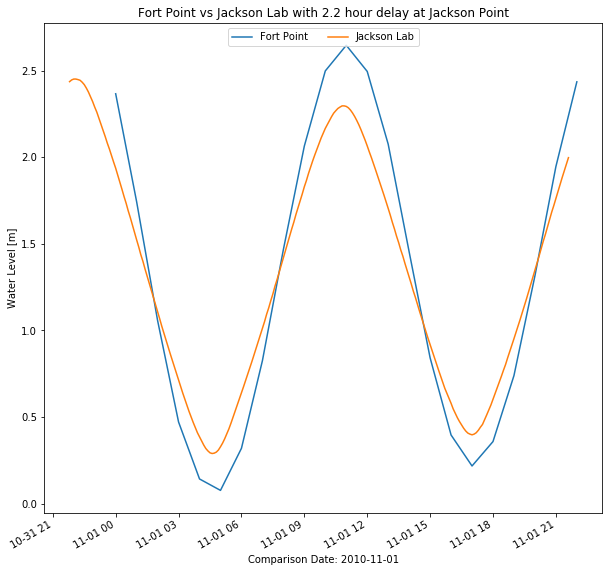

In [116]:
# Apply 2.2 hour time shift
t_s = t_jl.copy()
for idx in range(0,len(t_jl)):
    t_s[idx] = t_s[idx] - timedelta(hours=2.2)

plt.figure(figsize=(10, 10))
plt.plot(t_fp[idx_fp_s:idx_fp_e],wl_fp[idx_fp_s:idx_fp_e],label=u'Fort Point')
plt.plot(t_s[idx_jl_s:idx_jl_e],wl_jl[idx_jl_s:idx_jl_e],label=u'Jackson Lab')
plt.title('Fort Point vs Jackson Lab with 2.2 hour delay at Jackson Point')
plt.ylabel('Water Level [m]')
plt.xlabel('Comparison Date: '+str(comp_date))
plt.gcf().autofmt_xdate() # Make the x-label more readable    
plt.legend(ncol=2, loc='upper center')
plt.show()

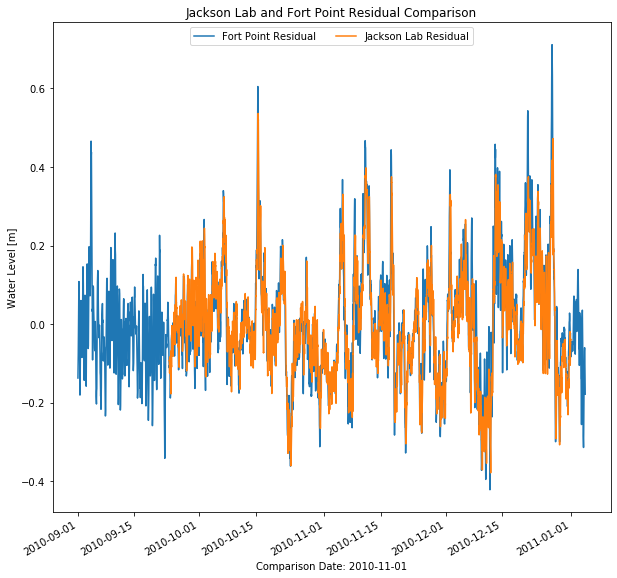

In [117]:
# Now let's compare residual data
plt.figure(figsize=(10, 10))
plt.plot(t_fp, wl_fp - tide_fp.h, label=u'Fort Point Residual', color='C0')
plt.plot(t_jl, wl_jl - tide_jl.h, label=u'Jackson Lab Residual', color='C1')

plt.title('Jackson Lab and Fort Point Residual Comparison')
plt.ylabel('Water Level [m]')
plt.xlabel('Comparison Date: '+str(comp_date))
plt.gcf().autofmt_xdate() # Make the x-label more readable    
plt.legend(ncol=2, loc='upper center')
plt.show()

     Number of blocks in transform = 2.0
     *** transforming ***
     *** Smoothing ***
['     NUMBER OF SMOOTHED POINTS  = 385']


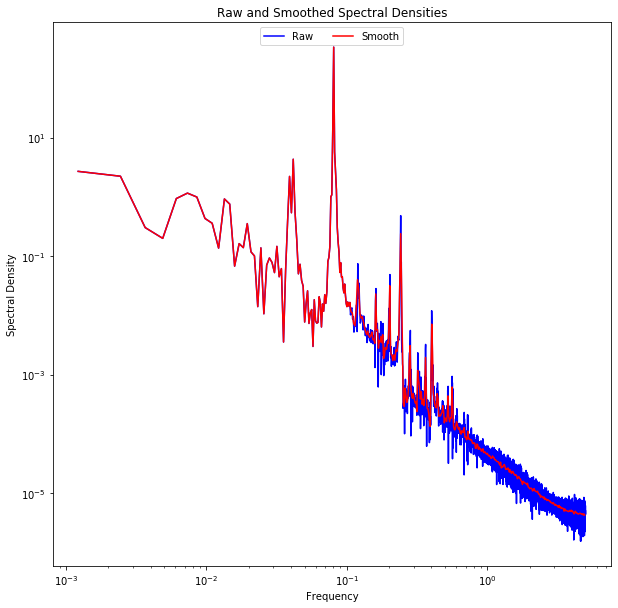

In [118]:
spec_jl = specter(wl_jl,2**13,.1,.005) 

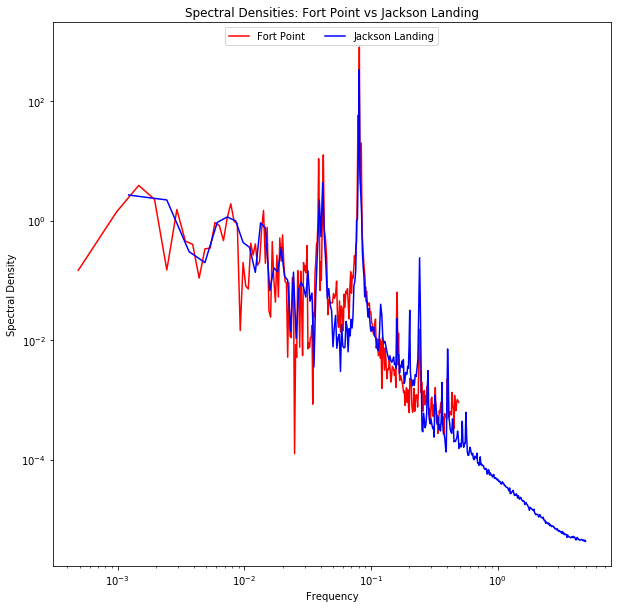

In [119]:
# Compare the spectra

plt.figure(figsize=(10, 10))
plt.loglog(spec_fp[:,0],spec_fp[:,1],'r',label=u'Fort Point')
plt.loglog(spec_jl[:,0],spec_jl[:,1],'b',label=u'Jackson Landing')
plt.title('Spectral Densities: Fort Point vs Jackson Landing')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.legend(ncol=2, loc='upper center')
plt.show()

In [120]:
c_jl

{'name': array(['M2', 'N2', 'K1', 'S2', 'L2', 'O1', 'MM', 'MU2', 'M6', 'MSF',
        '2MN6', 'MO3', 'EPS2', '2MS6', 'MK3', '2MK5', 'Q1', 'J1', 'NO1',
        'M4', 'UPS1', 'M3', 'MN4', 'ETA2', '3MK7', '2Q1', 'OO1', 'MS4',
        'M8', 'SK3', 'SN4', 'ALP1', '2SM6', 'S4', '2SK5'], dtype=object),
 'aux': {'frq': array([0.0805114 , 0.07899925, 0.04178075, 0.08333333, 0.08202355,
         0.03873065, 0.00151215, 0.07768947, 0.2415342 , 0.00282193,
         0.24002205, 0.11924206, 0.07617732, 0.24435613, 0.12229215,
         0.20280355, 0.0372185 , 0.0432929 , 0.04026859, 0.1610228 ,
         0.04634299, 0.1207671 , 0.15951065, 0.08507364, 0.28331495,
         0.03570635, 0.04483084, 0.16384473, 0.3220456 , 0.12511408,
         0.16233258, 0.03439657, 0.24717807, 0.16666667, 0.20844741]),
  'lind': array([ 47,  41,  20,  56,  53,  12,   4,  39, 105,   5, 102,  67,  34,
         109,  71,  95,  10,  24,  15,  81,  28,  68,  78,  60, 119,   8,
          27,  85, 124,  73,  83,   7, 112,  88,

prep/calcs ... done.


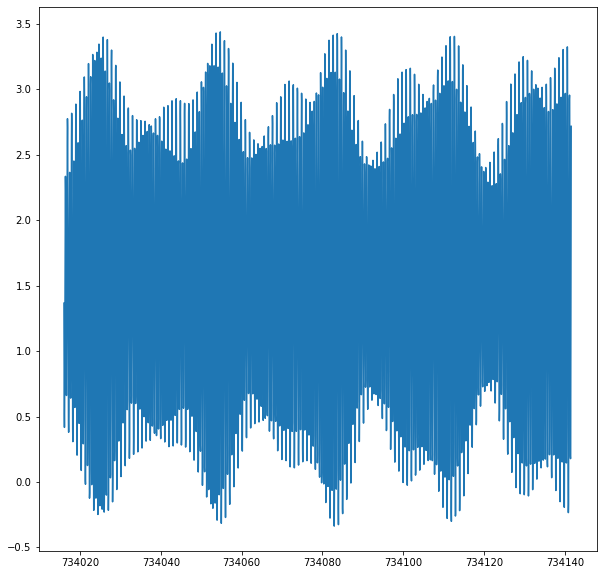

In [121]:
# make prediction for 5 most significant constituents at Fort Point

plt.figure(figsize=(10, 10))
pred_O1_fp = utide.reconstruct(time_fp, c_fp,constit=c_fp.name[0:5])
#(fpdn,nam(6,:),freq(6),fpcon(6,:),'latitude',43.07);
# K1pred=utide.reconstruct(fpdn,nam(8,:),freq(8),fpcon(8,:),'latitude',43.07);
# N2pred=utide.reconstruct(fpdn,nam(4,:),freq(14),fpcon(14,:),'latitude',43.07);
# M2pred=utide.reconstruct(fpdn,nam(15,:),freq(15),fpcon(15,:),'latitude',43.07);
# S2pred=utide.reconstruct(fpdn,nam(17,:),freq(17),fpcon(17,:),'latitude',43.07);

plt.plot(time_fp,pred_O1_fp.h)

In [122]:
c_fp.name[0:5]

array(['M2', 'N2', 'S2', 'K1', 'O1'], dtype=object)